In [45]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.models import vgg16_bn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import torchmetrics
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from guided_backprop import GuidedBackprop
import seaborn as sns
device = "cuda"

In [46]:
ds = CIFAR10(".",download=False)
ds_mean = (ds.data/255).mean((0,1,2))
ds_std = (ds.data/255).std((0,1,2))
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize(ds_mean,ds_std)
])
train_set = CIFAR10(".",download=False,train=True,transform=transform,target_transform=torch.tensor)
val_set = CIFAR10(".",download=False,train=False,transform=transform,target_transform=torch.tensor)
train_loader = DataLoader(train_set,batch_size=64,shuffle=True)
val_loader = DataLoader(val_set,batch_size=64,shuffle=False)


In [47]:
model = vgg16_bn()
model.classifier = nn.Sequential(nn.Linear(25088,4096),nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=4096, out_features=4096, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                  nn.Linear(in_features=4096, out_features=10, bias=True)
                                )

In [48]:
epochs = 50
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001,weight_decay=0.0005)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9,verbose=False)
accuracy = torchmetrics.Accuracy().to(device)
t_loss = []
v_loss = []
t_acc = []
v_acc = []

In [49]:
loop = trange(epochs)
for epoch in loop:
    model.train()
    r_loss = 0
    r_acc = 0
    for X,y in tqdm(train_loader,leave=False):
        X,y = X.to(device),y.to(device)
        out = model(X)
        loss = loss_fn(out,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        r_loss+= loss.item()
        with torch.no_grad():
            acc = accuracy(torch.argmax(out,1),y)
            r_acc +=acc.item()
    t_loss.append(r_loss/len(train_loader))
    t_acc.append(r_acc/len(train_loader))
    model.eval()
    r_loss = 0
    r_acc = 0
    with torch.no_grad():
        for X,y in tqdm(val_loader,leave=False):
            X,y = X.to(device),y.to(device)
            out = model(X)
            loss = loss_fn(out,y)
            r_loss+= loss.item()
            acc = accuracy(torch.argmax(out,1),y)
            r_acc +=acc.item()
    v_loss.append(r_loss/len(val_loader))
    v_acc.append(r_acc/len(val_loader))
    loop.set_postfix({"train loss":t_loss[-1],"val loss":v_loss[-1],
                     "train acc": t_acc[-1],"val acc": v_acc[-1]})
#     scheduler.step()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

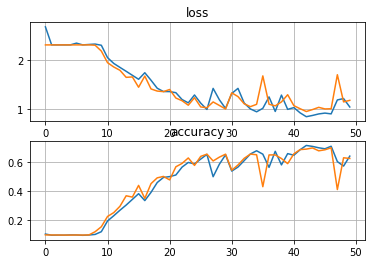

In [50]:
# torch.save({"model":model.state_dict()},"./model.pt")
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_loss,label="train")
plt.plot(v_loss,label="val")
plt.title("loss")
plt.grid("on")
plt.subplot(2,1,2)
plt.plot(t_acc,label="train")
plt.plot(v_acc,label="val")
plt.title("accuracy")
plt.grid("on")

In [6]:
chp = torch.load("model.pt")
model.load_state_dict(chp["model"])

<All keys matched successfully>

In [7]:
gbp = GuidedBackprop(model.cpu())

C:\Users\abbas\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping inp

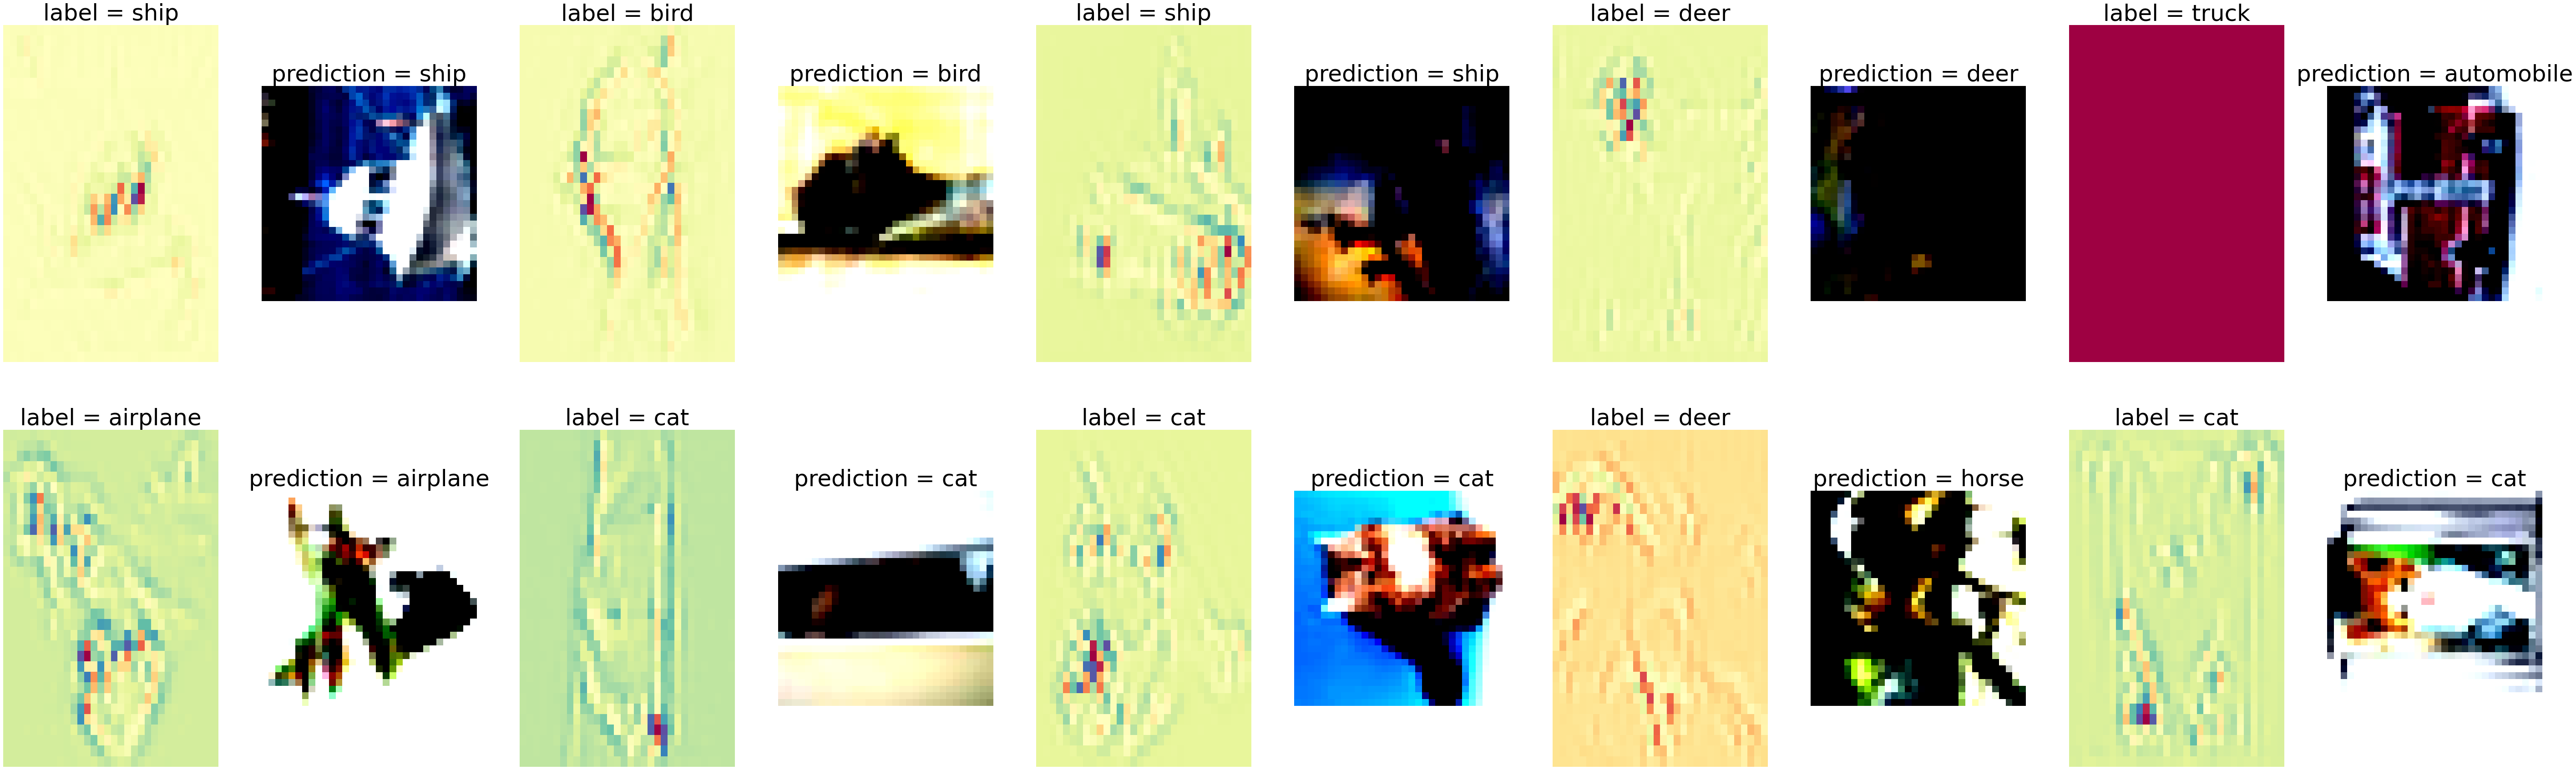

In [8]:

plt.figure(figsize=(100,30))
for i in range(10):
    plt.subplot(2,10,2*i+1)
    img, lbl = train_set[np.random.choice(len(train_set),1)[0]]
    img = img.unsqueeze(0)
    img = img
    lbl = lbl
    img.requires_grad = True
    grad_arr=gbp.generate_gradients(img,lbl)
    pred = model(img)
    pred = torch.argmax(pred,1)
    pred = pred.reshape(1)
    img = img.squeeze(0)
    img = img.detach().numpy()
    grad_arr_gray = grad_arr.mean(0)
    
    sns.heatmap(grad_arr_gray,cmap ="Spectral",cbar=False)
    
    
    plt.axis("off")
    plt.title(f"label = {train_set.classes[lbl.item()]}",fontsize=50)
    plt.subplot(2,10,2*i+2)
    plt.imshow(img.T)
    plt.axis("off")
    plt.title(f"prediction = {train_set.classes[pred.item()]}",fontsize=50)

In [9]:
X,y = next(iter(train_loader))
accs = []

for eps in range(10):
    if eps>0:
        X_fgm = fast_gradient_method(model, X, eps/10, np.inf)
        out = model(X_fgm)
    else:
        out = model(X)
    out = torch.argmax(out,1)
    accs.append(accuracy(out,y).item())


([<matplotlib.axis.XTick at 0x22933c70a90>,
 [Text(0, 0, '0'),
  Text(1, 0, '0.1'),
  Text(2, 0, '0.2'),
  Text(3, 0, '0.3'),
  Text(4, 0, '0.4'),
  Text(5, 0, '0.5'),
  Text(6, 0, '0.6'),
  Text(7, 0, '0.7'),
  Text(8, 0, '0.8'),
  Text(9, 0, '0.9')])

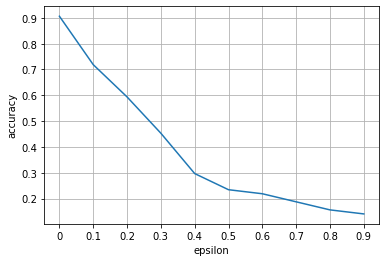

In [10]:
plt.plot(accs)
plt.grid("on")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.xticks(list(range(10)),labels=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9])

In [11]:
out = out.detach().numpy()
y = y.detach().numpy()
print(f"outputs for epsillon = {eps/10}")
for i in range(20):
    
    print(f"true = {train_set.classes[y[i]]}, predicted = {train_set.classes[out[i]]}")

outputs for epsillon = 0.9
true = cat, predicted = frog
true = bird, predicted = automobile
true = dog, predicted = automobile
true = horse, predicted = frog
true = bird, predicted = frog
true = automobile, predicted = automobile
true = ship, predicted = automobile
true = airplane, predicted = automobile
true = horse, predicted = automobile
true = ship, predicted = automobile
true = ship, predicted = automobile
true = horse, predicted = frog
true = horse, predicted = automobile
true = dog, predicted = automobile
true = horse, predicted = frog
true = horse, predicted = automobile
true = automobile, predicted = automobile
true = deer, predicted = automobile
true = ship, predicted = automobile
true = dog, predicted = automobile


In [14]:
model = vgg16_bn()
model.classifier = nn.Sequential(nn.Linear(25088,4096),nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=4096, out_features=4096, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                  nn.Linear(in_features=4096, out_features=10, bias=True)
                                )
epochs = 60
eps = 0.5
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.00001,weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9,verbose=False)
accuracy = torchmetrics.Accuracy().to(device)
t_loss = []
v_loss = []
t_acc = []
v_acc = []
v_acc_adv = []


In [15]:
loop = trange(epochs)
for epoch in loop:
    model.train()
    r_loss = 0
    r_acc = 0
    r_adv_loss = []
    t_loop = tqdm(enumerate(train_loader),leave=True,total=len(train_loader))
    for i,(X,y) in t_loop:
        
        X,y = X.to(device),y.to(device)
        p = np.random.choice(X.shape[0],int(X.shape[0]*0.4))
        p = p.tolist()
        X[p] = fast_gradient_method(model, X[p], eps, np.inf)
        X.detach()
        model.train()
        out = model(X)
        loss = loss_fn(out,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        r_loss+= loss.item()
        with torch.no_grad():
            acc = accuracy(torch.argmax(out,1),y)
            r_acc +=acc.item()
            t_loop.set_postfix({"loss":r_loss/(i+1),"acc":r_acc/(i+1)})
#             idx=(torch.argmax(out,1)==y).cpu().numpy()
#             idx = idx.tolist()
#             y = y[idx]
#             X = X[idx]
#         X = fast_gradient_method(model, X, eps, np.inf)
#         model.train()
#         optimizer.zero_grad()
#         out = model(X)
#         loss = loss_fn(out,y)
        
#         loss.backward()
#         optimizer.step()
#         r_adv_loss.append(loss.item())
#         t_loop.set_postfix({"running adv loss":np.mean(r_adv_loss)})
            
    t_loss.append(r_loss/len(train_loader))
    t_acc.append(r_acc/len(train_loader))
#     loss = np.mean(r_adv_loss)
#     print(loss)
#     t_loss_adv.append(loss)
    model.eval()
    r_loss = 0
    r_acc = 0
    r_acc_adv = []
    t_loop = tqdm(enumerate(val_loader),leave=True,total=len(val_loader))
    for i,(X,y) in t_loop:
        X,y = X.to(device),y.to(device)
        
        with torch.no_grad():
            
            out = model(X)
            loss = loss_fn(out,y)
            r_loss+= loss.item()
            acc = accuracy(torch.argmax(out,1),y)
            r_acc +=acc.item()
            idx=(torch.argmax(out,1)==y).cpu().numpy()
            idx = idx.tolist()
            X = X[idx]
            y = y[idx]
        X = fast_gradient_method(model, X, eps, np.inf)
        with torch.no_grad():
            X = X.cuda()
            out = model(X)
            acc = (torch.argmax(out,1)==y).sum()/out.shape[0]
            
            r_acc_adv.append(acc.item())
            t_loop.set_postfix({"loss":r_loss/(i+1),"acc":r_acc/(i+1),"adv acc":np.mean(r_acc_adv)})
    v_loss.append(r_loss/len(val_loader))
    v_acc.append(r_acc/len(val_loader))
    v_acc_adv.append(np.mean(r_acc_adv))
    loop.set_postfix({"train loss":t_loss[-1],"val loss":v_loss[-1],
                     "train acc": t_acc[-1],"val acc": v_acc[-1],
                     "val adv acc":v_acc_adv[-1]})
    scheduler.step()

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

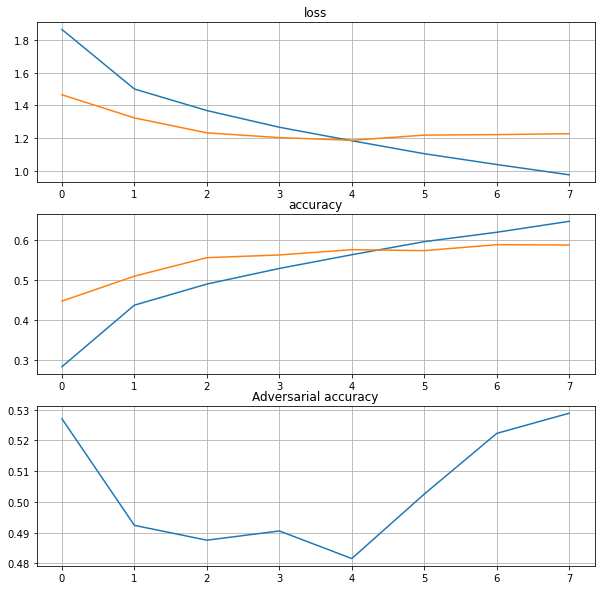

In [18]:
plt.figure(figsize=[10,10])
plt.subplot(3,1,1)
plt.plot(t_loss,label="train")
plt.plot(v_loss,label="val")
plt.title("loss")
plt.grid("on")
plt.subplot(3,1,2)
plt.plot(t_acc,label="train")
plt.plot(v_acc,label="val")
plt.title("accuracy")
plt.grid("on")
plt.subplot(3,1,3)
plt.plot(v_acc_adv)
plt.title("Adversarial accuracy")
plt.grid("on")

C:\Users\abbas\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping inp

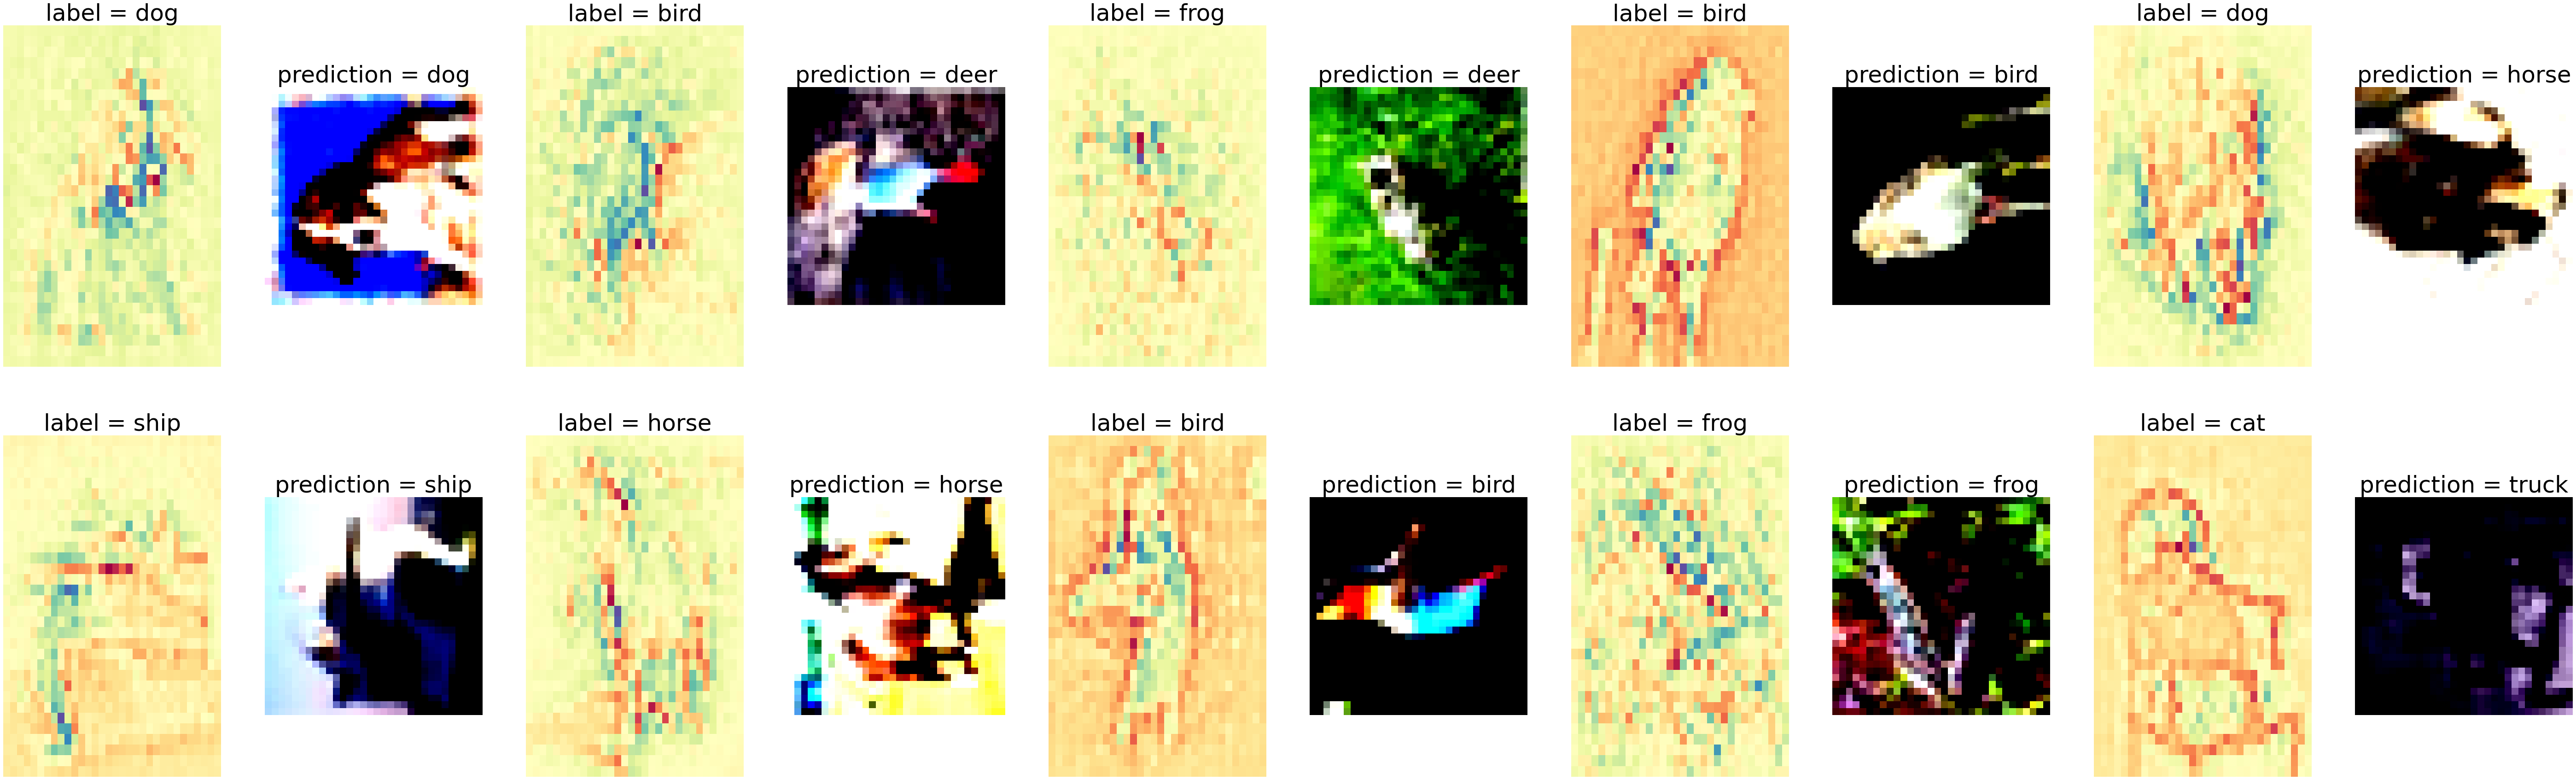

In [19]:
gbp = GuidedBackprop(model.cpu())
plt.figure(figsize=(100,30))
for i in range(10):
    plt.subplot(2,10,2*i+1)
    img, lbl = train_set[np.random.choice(len(train_set),1)[0]]
    img = img.unsqueeze(0)
    img = img
    lbl = lbl
    img.requires_grad = True
    grad_arr=gbp.generate_gradients(img,lbl)
    pred = model(img)
    pred = torch.argmax(pred,1)
    pred = pred.reshape(1)
    img = img.squeeze(0)
    img = img.detach().numpy()
    grad_arr_gray = grad_arr.mean(0)
    
    sns.heatmap(grad_arr_gray,cmap ="Spectral",cbar=False)
    
    
    plt.axis("off")
    plt.title(f"label = {train_set.classes[lbl.item()]}",fontsize=50)
    plt.subplot(2,10,2*i+2)
    plt.imshow(img.T)
    plt.axis("off")
    plt.title(f"prediction = {train_set.classes[pred.item()]}",fontsize=50)

In [21]:
X,y = next(iter(train_loader))
accs = []


X_fgm = fast_gradient_method(model, X, eps, np.inf)
out = model(X_fgm)

out = torch.argmax(out,1)
acc = (accuracy(out,y).item())
out = out.detach().numpy()
y = y.detach().numpy()
print(f"outputs for epsillon = {eps}")
for i in range(len(X)):
    
    print(f"true = {train_set.classes[y[i]]}, predicted = {train_set.classes[out[i]]}")

outputs for epsillon = 0.5
true = airplane, predicted = airplane
true = dog, predicted = horse
true = frog, predicted = automobile
true = dog, predicted = cat
true = deer, predicted = airplane
true = dog, predicted = cat
true = horse, predicted = horse
true = cat, predicted = dog
true = bird, predicted = airplane
true = deer, predicted = frog
true = bird, predicted = frog
true = airplane, predicted = automobile
true = frog, predicted = truck
true = automobile, predicted = truck
true = horse, predicted = horse
true = cat, predicted = frog
true = automobile, predicted = automobile
true = frog, predicted = truck
true = airplane, predicted = truck
true = horse, predicted = horse
true = deer, predicted = dog
true = deer, predicted = truck
true = dog, predicted = dog
true = bird, predicted = bird
true = airplane, predicted = airplane
true = bird, predicted = horse
true = deer, predicted = truck
true = airplane, predicted = truck
true = truck, predicted = truck
true = bird, predicted = dog
tr

In [37]:
img,lbl = train_set[19]
img = img.unsqueeze(0)
X_fgm = fast_gradient_method(model, img, eps, np.inf)

<AxesSubplot:>

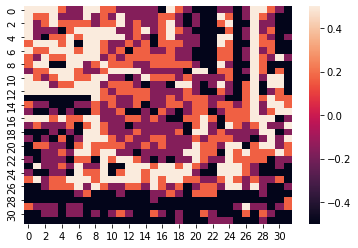

In [31]:
diff = img-X_fgm
sns.heatmap((diff.squeeze().detach().numpy()).mean(0))

In [40]:
# img.requires_grad =True
grad_arr=gbp.generate_gradients(img,lbl)
# X_fgm.requires_grad = True
grad_arr_fgm=gbp.generate_gradients(X_fgm,lbl)

Text(0.5, 1.0, 'difference')

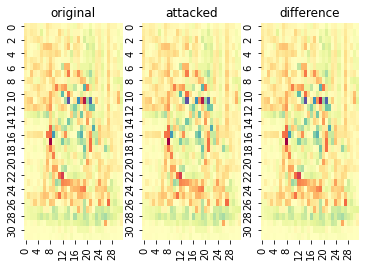

In [43]:
plt.subplot(1,3,1)
grad_arr_gray = grad_arr.mean(0)

sns.heatmap(grad_arr_gray,cmap ="Spectral",cbar=False)
plt.title("original")
plt.subplot(1,3,2)
grad_arr__fgm_gray = grad_arr_fgm.mean(0)

sns.heatmap(grad_arr_gray,cmap ="Spectral",cbar=False)
plt.title("attacked")

plt.subplot(1,3,3)
grad_arr_diff = grad_arr-grad_arr_fgm
grad_arr__diff_gray = grad_arr_diff.mean(0)

sns.heatmap(grad_arr_gray,cmap ="Spectral",cbar=False)
plt.title("difference")
